In [143]:
using JIVECore, FFTW, BenchmarkTools

In [144]:
# FFTW.set_provider!("mkl")
FFTW.get_provider()

"fftw"

## Load Data

In [145]:
path = "images/WBTestData/PSF.tif"
psf = JIVECore.Files.loadImage(path);
# JIVECore.Process.autoContrast(psf_cy3[:, :, 52])
psf = JIVECore.Data.im2float(psf);

In [146]:
size(psf)

(128, 128, 128)

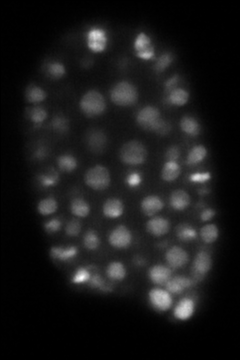

In [147]:
path = "images/WBTestData/Stack_1.tif"
img = JIVECore.Files.loadImage(path);
img_slice = JIVECore.Process.autoContrast(img[:, :, 123])


In [148]:
psf2, _ = JIVECore.Process.imMatching(psf, img, method="replicate", collect_arrays=true)
size(psf2)

(360, 240, 246)

In [149]:
img = JIVECore.Data.im2float(img);

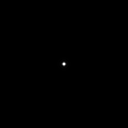

In [150]:
JIVECore.Process.autoContrast(JIVECore.Data.Gray.(psf[:, :, 64]))

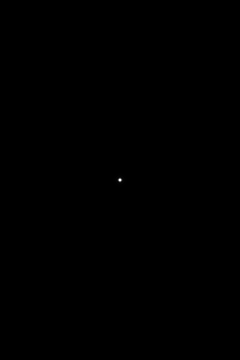

In [151]:
JIVECore.Process.autoContrast(JIVECore.Data.Gray.(psf2[:, :, 123]))

In [152]:
psf2_shift = ifftshift(psf2);

---
## Traditional RL deconvolution

In [153]:
img_dec = JIVECore.Process.deconvRL(img, psf2_shift, regularizer=nothing, iterations=10);


In [154]:
@benchmark JIVECore.Process.deconvRL(img, psf2_shift, regularizer=nothing, iterations=10)

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 7.053 s (0.00% GC) to evaluate,
 with a memory estimate of 568.91 MiB, over 33 allocations.

In [155]:
img_dec_slice = JIVECore.Process.autoContrast(img_dec[:, :, 123]);

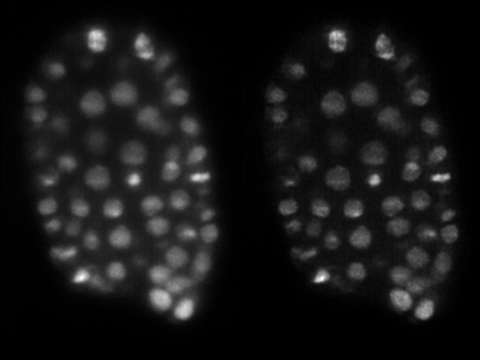

In [156]:
JIVECore.Visualize.mosaicview(img_slice, img_dec_slice; nrow = 1)

In [157]:
# @benchmark JIVECore.Process.deconvRL(cy3, psf_cy3_shift, regularizer=nothing, iterations=1) samples=10 evals=10 seconds=120

### Save

In [158]:
using FileIO

In [159]:
"""
    normalize_stack(stack::Array{T,3}) where T<:Real

Normalizes a 3D array so that all values are scaled linearly to the [0.0, 1.0] range,
based on the global minimum and maximum values in the stack.

# Arguments:
- `stack`: A 3D array (e.g., height × width × depth) of real numbers.

# Returns:
- A 3D array of `Float32` values in the range [0.0, 1.0].
"""
function normalize_stack(stack::Array{T,3}) where T<:Real
    minval = minimum(stack)
    maxval = maximum(stack)
    range = maxval - minval
    @assert range > 0 "Stack has no dynamic range (all values are equal)."
    return Float32.((stack .- minval) ./ range)
end



normalize_stack

In [160]:
function saveImageStack(stack::Array{T,3}, filename::String; overwrite::Bool=false) where T<:Real
    try
        if !overwrite && isfile(filename)
            error("File $filename already exists. Use `overwrite=true` to overwrite it.")
        end
        stack = normalize_stack(stack)
        FileIO.save(filename, stack)
    catch e
        println(e.msg)  # Print only the error message
    end
end

saveImageStack (generic function with 1 method)

In [161]:
saveImageStack(img_dec, "images/WBTestData/Stack_1_deconvolved.tif")

File images/WBTestData/Stack_1_deconvolved.tif already exists. Use `overwrite=true` to overwrite it.


---

# WB backpropagation

In [162]:
PSF_bp, _ = JIVECore.Process.BackProjector(psf2; bp_type="wiener-butterworth", alpha=0.05, beta=1, n=10, resFlag=1, iRes=[2.44, 2.44, 2.44], verboseFlag=false);
psf_bp_shift = ifftshift(PSF_bp);

In [163]:
img_dec2 = JIVECore.Process.deconvRL(img, psf2_shift, psf_bp_shift, regularizer=nothing, iterations=1);

In [164]:
@benchmark JIVECore.Process.deconvRL(img, psf2_shift, psf_bp_shift, regularizer=nothing, iterations=1) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 1.331 s (0.16% GC) to evaluate,
 with a memory estimate of 812.60 MiB, over 58 allocations.

In [165]:
img_dec2_slice = JIVECore.Process.autoContrast(img_dec2[:, :, 123]);

In [166]:
saveImageStack(img_dec2, "images/WBTestData/Stack_1_deconvolved_WB.tif")

File images/WBTestData/Stack_1_deconvolved_WB.tif already exists. Use `overwrite=true` to overwrite it.


---
## Comparison

In [167]:
img_dec_1iter = JIVECore.Process.deconvRL(img, psf2_shift, regularizer=nothing, iterations=1);


In [168]:
@benchmark JIVECore.Process.deconvRL(img, psf2_shift, regularizer=nothing, iterations=1) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 1.012 s (0.00% GC) to evaluate,
 with a memory estimate of 568.91 MiB, over 33 allocations.

In [169]:
img_dec_1iter_slice = JIVECore.Process.autoContrast(img_dec_1iter[:, :, 123]);

   Original / Traditional (1 Iteration) / Traditional (10 Iterations) / WB Deconvolved (1 Iteration)  


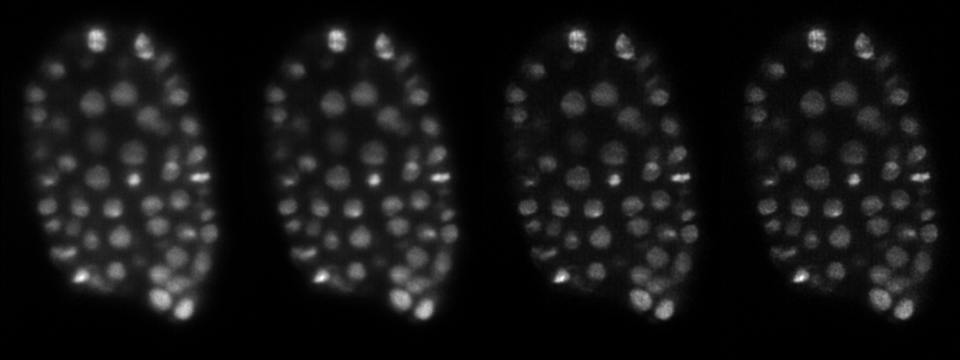

In [170]:
println("   Original / ", "Traditional (1 Iteration) / ",
         "Traditional (10 Iterations) / ", "WB Deconvolved (1 Iteration)  ")
JIVECore.Visualize.mosaicview(img_slice, img_dec_1iter_slice, img_dec_slice, img_dec2_slice; nrow = 1)

RESULTADOS MATLAB

In [171]:
path = "images/WBTestData/results/DeconTradicional1iter.tif"
img_dec_1iter_MATLAB = JIVECore.Files.loadImage(path);
# JIVECore.Process.autoContrast(psf_cy3[:, :, 52])
img_dec_1iter_MATLAB = JIVECore.Data.im2float(img_dec_1iter_MATLAB);
img_dec_1iter_slice_MATLAB = JIVECore.Process.autoContrast(img_dec_1iter_MATLAB[:, :, 123]);

In [172]:
path = "images/WBTestData/results/DeconTradicional10iter.tif"
img_dec_10iter_MATLAB = JIVECore.Files.loadImage(path);
# JIVECore.Process.autoContrast(psf_cy3[:, :, 52])
img_dec_10iter_MATLAB = JIVECore.Data.im2float(img_dec_10iter_MATLAB);
img_dec_10iter_slice_MATLAB = JIVECore.Process.autoContrast(img_dec_10iter_MATLAB[:, :, 123]);

In [173]:
path = "images/WBTestData/results/DeconWB1iter.tif"
img_dec_1iter_MATLAB_wb = JIVECore.Files.loadImage(path);
# JIVECore.Process.autoContrast(psf_cy3[:, :, 52])
img_dec_1iter_MATLAB_wb = JIVECore.Data.im2float(img_dec_1iter_MATLAB_wb);
img_dec_1iter_slice_MATLAB_wb = JIVECore.Process.autoContrast(img_dec_1iter_MATLAB_wb[:, :, 123]);

   Original / Traditional (1 Iteration) / Traditional (10 Iterations) / WB Deconvolved (1 Iteration)  


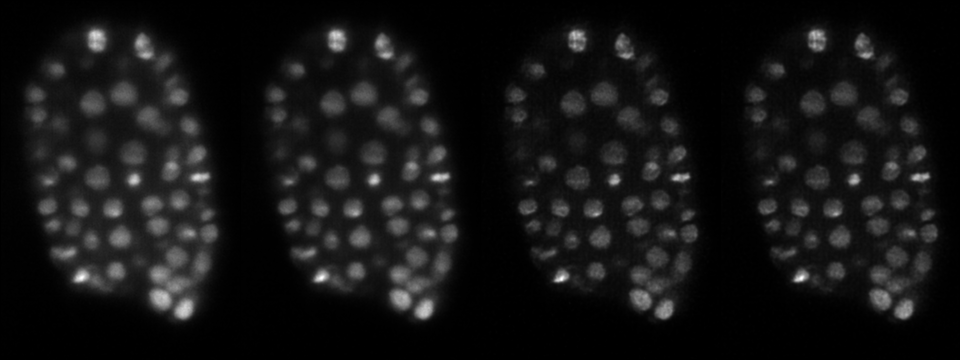

In [174]:
println("   Original / ", "Traditional (1 Iteration) / ",
         "Traditional (10 Iterations) / ", "WB Deconvolved (1 Iteration)  ")
JIVECore.Visualize.mosaicview(img_slice, img_dec_1iter_slice_MATLAB, img_dec_10iter_slice_MATLAB, img_dec_1iter_slice_MATLAB_wb; nrow = 1)

   Original / Traditional (1 Iteration) / Traditional (10 Iterations) / WB Deconvolved (1 Iteration)  


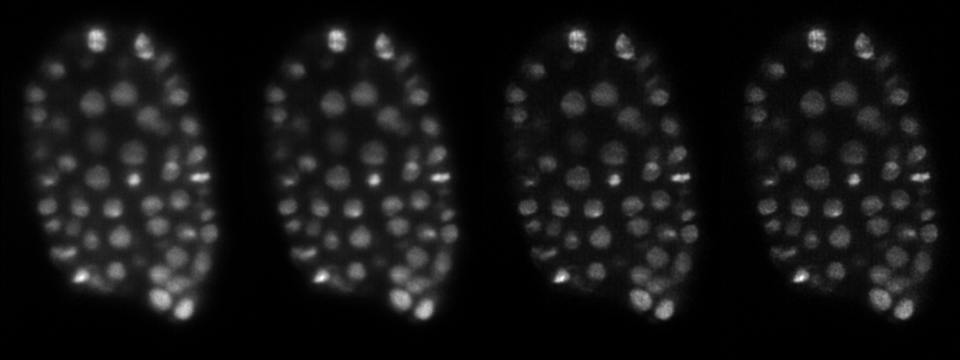

In [175]:
using FileIO           # para `save(...)`
using JIVECore         # tu módulo
# NO uses ImageIO aquí

# Crear mosaico visual
println("   Original / Traditional (1 Iteration) / Traditional (10 Iterations) / WB Deconvolved (1 Iteration)  ")

mosaic1 = JIVECore.Visualize.mosaicview(
    img_slice,
    img_dec_1iter_slice,
    img_dec_slice,
    img_dec2_slice;
    nrow = 1
)

# Guardar como archivo PNG
#save("resultado_mosaico_MATLAB.png", mosaic)


TABLA COMPARATIVA DE TIEMPOS

In [1]:
using PrettyTables

data = [
    "Tradicional 1 iteración"     3.761421   1.011;
    "Tradicional 10 iteraciones"  21.22845   7.133;
    "WBDeconvolution 1 iteración" 3.849222   1.341
]

pretty_table(HTML, data; header = ["TIEMPO (s)", "MATLAB", "JULIA"])


TIEMPO (s),MATLAB,JULIA
Tradicional 1 iteración,3.76142,1.011
Tradicional 10 iteraciones,21.2284,7.133
WBDeconvolution 1 iteración,3.84922,1.341
